# US Name

Estimate asset_tangibility as a function of  financial ratio and others (estimate table 6 Andersen, etc) 

# Business needs 

Estimate asset_tangibility as a function of  financial ratio, credit constraint, city policy mandate, tcz, spz, capital, employment, sales, output (Replicate table 6 Andersen Determinants of firm-level asset tangibility., Add proxy to firm size like output, sales, employment separately, add more parameters to the model specific to China like policy mandate, tcz, spz) 

## Description
### Objective 

Test the coefficient sign and significant of the main variable

### Tables

1. Table 1: Baseline Estimate, determinants of firm-level asset tangibility.
  1. asset_tangibility and financial ratio, credit constraint, city policy mandate, tcz, spz, capital, employment, sales, output

**Cautious**
Make sure no empty rows, otherwise it will be filtered out in the estimate


# Metadata

- Key: bnj64hblu96864v
- Epic: Models
- US: Firm level estimate
- Task tag: #analytics, #firm-level, #tangible-asset, #andersen
- Analytics reports: 

# Input Cloud Storage

## Table/file

**Name** 

- https://github.com/thomaspernet/Financial_dependency_pollution/blob/master/01_data_preprocessing/02_transform_tables/06_asif_financial_ratio_firm_baseline.md

**Github**

- DATA/ECON/FIRM_SURVEY/ASIF_CHINA/TRANSFORMED/FINANCIAL_RATIO/FIRM



# Connexion server

In [1]:
from awsPy.aws_authorization import aws_connector
from awsPy.aws_s3 import service_s3
from awsPy.aws_glue import service_glue
from pathlib import Path
import pandas as pd
import numpy as np
#import seaborn as sns
import os, shutil, json

path = os.getcwd()
parent_path = str(Path(path).parent.parent.parent)


name_credential = 'financial_dep_SO2_accessKeys.csv'
region = 'eu-west-3'
bucket = 'datalake-datascience'
path_cred = "{0}/creds/{1}".format(parent_path, name_credential)

In [2]:
con = aws_connector.aws_instantiate(credential = path_cred,
                                       region = region)
client= con.client_boto()
s3 = service_s3.connect_S3(client = client,
                      bucket = bucket, verbose = False)
glue = service_glue.connect_glue(client = client) 

In [3]:
pandas_setting = True
if pandas_setting:
    #cm = sns.light_palette("green", as_cmap=True)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'


# Load tables

Since we load the data as a Pandas DataFrame, we want to pass the `dtypes`. We load the schema from Glue to guess the types

In [5]:
db = 'firms_survey'
table = 'asif_financial_ratio_baseline_firm'

In [6]:
dtypes = {}
schema = (glue.get_table_information(database = db,
                           table = table)
          ['Table']['StorageDescriptor']['Columns']
         )
for key, value in enumerate(schema):
    if value['Type'] in ['varchar(12)']:
        format_ = 'string'
    elif value['Type'] in ['decimal(21,5)', 'double', 'bigint', 'int', 'float']:
        format_ = 'float'
    else:
        format_ = value['Type'] 
    dtypes.update(
        {value['Name']:format_}
    )

In [7]:
download_data = False
filename = 'df_{}'.format(table)
full_path_filename = 'SQL_OUTPUT_ATHENA/CSV/{}.csv'.format(filename)
path_local = os.path.join(str(Path(path).parent.parent.parent), 
                              "00_data_catalogue/temporary_local_data")
df_path = os.path.join(path_local, filename + '.csv')
if download_data:
    
    s3 = service_s3.connect_S3(client = client,
                          bucket = bucket, verbose = False)
    query = """
    SELECT * 
    FROM {}.{}
    """.format(db, table)
    df = (s3.run_query(
        query=query,
        database=db,
        s3_output='SQL_OUTPUT_ATHENA',
        filename=filename,  # Add filename to print dataframe
        destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
        dtype = dtypes
    )
            )
    s3.download_file(
        key = full_path_filename
    )
    shutil.move(
        filename + '.csv',
        os.path.join(path_local, filename + '.csv')
    )
    s3.remove_file(full_path_filename)
    df.head()

In [8]:
pd.DataFrame(schema)

,Name,Type,Comment
0,firm,string,Firms ID
1,year,string,
2,period,varchar(5),if year prior to 2006 then False else true. Indicate break from 10 and 11 FYP
3,cic,string,4 digits industry code
4,indu_2,string,"Two digits industry. If length cic equals to 3, then add 0 to indu_2"
5,short,string,Industry short description
6,geocode4_corr,string,city code
7,tcz,string,Two control zone policy
8,spz,string,Special policy zone
9,ownership,string,Firms ownership


## Schema Latex table

To rename a variable, please use the following template:

```
{
    'old':'XX',
    'new':'XX_1'
    }
```

if you need to pass a latex format with `\`, you need to duplicate it for instance, `\text` becomes `\\text:

```
{
    'old':'working\_capital\_i',
    'new':'\\text{working capital}_i'
    }
```

Then add it to the key `to_rename`

In [9]:
add_to_dic = True

if add_to_dic:
    if os.path.exists("schema_table.json"):
        os.remove("schema_table.json")
        data = {'to_rename':[], 'to_remove':[]}
    dic_rename = [
        ### control variables
        {
        'old':'output',
        'new':'\\text{output}_{cit}'
        },
        {
        'old':'employment',
        'new':'\\text{employment}_{cit}'
        },
        {
        'old':'capital',
        'new':'\\text{capital}_{cit}'
        },
        {
        'old':'sales',
        'new':'\\text{sales}_{cit}'
        },
        {
        'old':'total\_asset',
        'new':'\\text{total asset}_{cit}'
        },
        ####
        {
        'old':'asset\_tangibility\_fcit',
        'new':'\\text{asset tangibility}_{fcit}'
        },
        {
        'old':'cash\_over\_totasset\_fcit',
        'new':'\\text{cash over asset}_{fcit}'
        },
        {
        'old':'lag\_cash\_over\_totasset\_fcit',
        'new':'\\text{cash over asset}_{fcit}'
        },
        {
        'old':'sales\_assets\_andersen\_fcit',
        'new':'\\text{sales over assets}_{fcit}'
        },
        {
        'old':'return\_on\_asset\_fcit',
        'new':'\\text{return on asset}_{fcit}'
        },
        {
        'old':'liabilities\_assets\_fcit',
        'new':'\\text{liabilities assets}_{fcit}'
        },
        {
        'old':'lag\_liabilities\_assets\_fcit',
        'new':'\\text{liabilities assets}_{fcit}'
        },
        {
        'old':'quick\_ratio\_fcit',
        'new':'\\text{quick ratio}_{fcit}'
        },
        {
        'old':'lag\_quick\_ratio\_fcit',
        'new':'\\text{quick ratio}_{fcit}'
        },
        {
        'old':'current\_ratio\_fcit',
        'new':'\\text{current ratio}_{fcit}'
        },
        {
        'old':'lag\_current\_ratio\_fcit',
        'new':'\\text{current ratio}_{fcit}'
        },
        {
        'old':'d\_credit\_constraintBELOW',
        'new':'\\text{Fin dep}_{i}'
        }
    ]

    data['to_rename'].extend(dic_rename)
    with open('schema_table.json', 'w') as outfile:
        json.dump(data, outfile)

In [10]:
import function.latex_beautify as lb

#%load_ext autoreload
#%autoreload 2

In [11]:
options(warn=-1)
library(tidyverse)
library(lfe)
#library(lazyeval)
library('progress')
path = "function/table_golatex.R"
source(path)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand


Please cite as: 

 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 



In [12]:
%get df_path
df_final <- read_csv(df_path) %>%
mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("fe")), as.factor) %>%
mutate(
    period = relevel(as.factor(period), ref='FALSE'),
    soe_vs_pri = relevel(as.factor(soe_vs_pri), ref='SOE'),
    #asset_tangibility_fcit = asset_tangibility_fcit /1000000000,
    #cash_over_totasset_fcit = cash_over_totasset_fcit /100000,
    #liabilities_assets_fcit = liabilities_assets_fcit /100000,
)

Parsed with column specification:
cols(
  .default = col_double(),
  period = col_logical(),
  short = col_character(),
  ownership = col_character(),
  soe_vs_pri = col_character(),
  for_vs_dom = col_character(),
  d_credit_constraint = col_character()
)
See spec(...) for full column specifications.


## 1. Table 1: Baseline Estimate, determinants of firm-level asset tangibility.

$$
\begin{aligned}
\text { Asset Tangibility }_{f i t}=\delta_{7} \text { Current Ratio }_{f i t-1}+\delta_{8} \text { Cash/Assets }_{f i t-1}+\delta_{9} \text { Liabilities/Assets }_{f i t-1}+\Lambda_{\text {fit }}^{\prime} X+\vartheta_{i t}+u_{\text {fit }}
\end{aligned}
$$


* Column 1: Baseline
    * FE: 
        - fe 1: `firm`
* Column 2: Add control
    * FE: 
        - fe 1: `firm`
* Column 3: Test credit constraint interaction
    * FE: 
        - fe 1: `firm`
        
![](https://drive.google.com/uc?export=view&id=12uyrdOY5hskcWeH9ZlU8y4MazgEeEHWK)

In [ ]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [ ]:
%get path table
t_0 <- felm(log(asset_tangibility_fcit) ~ log(current_ratio_fcit) +
            log(cash_over_totasset_fcit) +
            log(liabilities_assets_fcit)
            | firm + fe_t_i|0 | firm, df_final,
            exactDOF = TRUE)

t_1 <- felm(log(asset_tangibility_fcit) ~ log(current_ratio_fcit) +
            log(cash_over_totasset_fcit) + 
            log(liabilities_assets_fcit) +
            log(sales_assets_andersen_fcit) 
            | firm+ fe_t_i|0 | firm,df_final,
            exactDOF = TRUE)

t_2 <- felm(log(asset_tangibility_fcit) ~ log(current_ratio_fcit) +
            log(cash_over_totasset_fcit) + 
            log(liabilities_assets_fcit) +
            log(current_ratio_fcit) * d_credit_constraint  + 
            log(cash_over_totasset_fcit) * d_credit_constraint + 
            log(liabilities_assets_fcit) * d_credit_constraint
            | firm+ fe_t_i|0 | firm, df_final,
            exactDOF = TRUE)

### more controls
t_3 <- felm(log(asset_tangibility_fcit) ~ log(current_ratio_fcit) +
            log(cash_over_totasset_fcit) + 
            log(liabilities_assets_fcit) +
            log(output)
            | firm + fe_t_i|0 | firm,df_final,
            exactDOF = TRUE)

t_4 <- felm(log(asset_tangibility_fcit) ~ log(current_ratio_fcit) +
            log(cash_over_totasset_fcit) +
            log(liabilities_assets_fcit) +
            log(sales_assets_andersen_fcit) +
            log(output)
            | firm+ fe_t_i|0 | firm, df_final,
            exactDOF = TRUE)

t_5 <- felm(log(asset_tangibility_fcit) ~ log(current_ratio_fcit) +
            log(cash_over_totasset_fcit) +
            log(liabilities_assets_fcit) +
            log(current_ratio_fcit) * d_credit_constraint  + 
            log(cash_over_totasset_fcit) * d_credit_constraint + 
            log(liabilities_assets_fcit) * d_credit_constraint + 
            log(output)
            | firm+ fe_t_i|0 | firm,df_final,
            exactDOF = TRUE)
            
dep <- "Dependent variable: Asset tangilibility"
fe1 <- list(
    c("firm", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5
),
    title="Baseline Estimate, determinants of firm-level asset tangibility",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

In [ ]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the firm level appear in parentheses."\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multicolumn ={
#    'Eligible': 2,
#    'Non-Eligible': 1,
#    'All': 1,
#    'All benchmark': 1,
#}

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200,
            folder = folder)

Lagged value

In [ ]:
folder = 'Tables_0'
table_nb = 2
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [ ]:
%get path table
t_0 <- felm(log(asset_tangibility_fcit) ~ log(lag_current_ratio_fcit) +
            log(lag_cash_over_totasset_fcit) +
            log(lag_liabilities_assets_fcit)
            | firm + fe_t_i|0 | firm, df_final,
            exactDOF = TRUE)

t_1 <- felm(log(asset_tangibility_fcit) ~ log(lag_current_ratio_fcit) +
            log(lag_cash_over_totasset_fcit) + 
            log(lag_liabilities_assets_fcit) +
            log(sales_assets_andersen_fcit) 
            | firm+ fe_t_i|0 | firm,df_final,
            exactDOF = TRUE)

t_2 <- felm(log(asset_tangibility_fcit) ~ log(lag_current_ratio_fcit) +
            log(lag_cash_over_totasset_fcit) + 
            log(lag_liabilities_assets_fcit) +
            log(lag_current_ratio_fcit) * d_credit_constraint  + 
            log(lag_cash_over_totasset_fcit) * d_credit_constraint + 
            log(lag_liabilities_assets_fcit) * d_credit_constraint
            | firm+ fe_t_i|0 | firm, df_final,
            exactDOF = TRUE)

### more controls
t_3 <- felm(log(asset_tangibility_fcit) ~ log(lag_current_ratio_fcit) +
            log(lag_cash_over_totasset_fcit) + 
            log(lag_liabilities_assets_fcit) +
            log(output)
            | firm + fe_t_i|0 | firm,df_final,
            exactDOF = TRUE)

t_4 <- felm(log(asset_tangibility_fcit) ~ log(lag_current_ratio_fcit) +
            log(lag_cash_over_totasset_fcit) +
            log(lag_liabilities_assets_fcit) +
            log(sales_assets_andersen_fcit) +
            log(output)
            | firm+ fe_t_i|0 | firm, df_final,
            exactDOF = TRUE)

t_5 <- felm(log(asset_tangibility_fcit) ~ log(lag_current_ratio_fcit) +
            log(lag_cash_over_totasset_fcit) +
            log(lag_liabilities_assets_fcit) +
            log(lag_current_ratio_fcit) * d_credit_constraint  + 
            log(lag_cash_over_totasset_fcit) * d_credit_constraint + 
            log(lag_liabilities_assets_fcit) * d_credit_constraint + 
            log(output)
            | firm+ fe_t_i|0 | firm,df_final,
            exactDOF = TRUE)
            
dep <- "Dependent variable: Asset tangilibility"
fe1 <- list(
    c("firm", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5
),
    title="Baseline Estimate, determinants of firm-level asset tangibility (lagged)",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

In [ ]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the firm level appear in parentheses."\
" Current ratio, cash over asset and liabilities over asset are lagged by one year. "\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multicolumn ={
#    'Eligible': 2,
#    'Non-Eligible': 1,
#    'All': 1,
#    'All benchmark': 1,
#}

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200,
            folder = folder)

### Private vs SOE

In [13]:
folder = 'Tables_0'
table_nb = 2
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [14]:
%get path table
t_0 <- felm(log(asset_tangibility_fcit) ~ log(current_ratio_fcit) +
            log(cash_over_totasset_fcit) + 
            log(liabilities_assets_fcit) +
            log(current_ratio_fcit) * soe_vs_pri  + 
            log(cash_over_totasset_fcit) * soe_vs_pri + 
            log(liabilities_assets_fcit)  * soe_vs_pri
            | firm+ fe_t_i|0 | firm, df_final,
            exactDOF = TRUE)

### more controls
t_1 <- felm(log(asset_tangibility_fcit) ~ log(current_ratio_fcit) +
            log(cash_over_totasset_fcit) +
            log(liabilities_assets_fcit) +
            log(current_ratio_fcit)  * soe_vs_pri  + 
            log(cash_over_totasset_fcit)  * soe_vs_pri + 
            log(liabilities_assets_fcit)  * soe_vs_pri + 
            log(output)
            | firm+ fe_t_i|0 | firm,df_final,
            exactDOF = TRUE)
            
dep <- "Dependent variable: Asset tangilibility"
fe1 <- list(
    c("firm", "Yes", "Yes"),
    c("industry-year", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0,t_1
),
    title="Baseline Estimate, determinants of firm-level asset tangibility (SOE vs PRI)",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

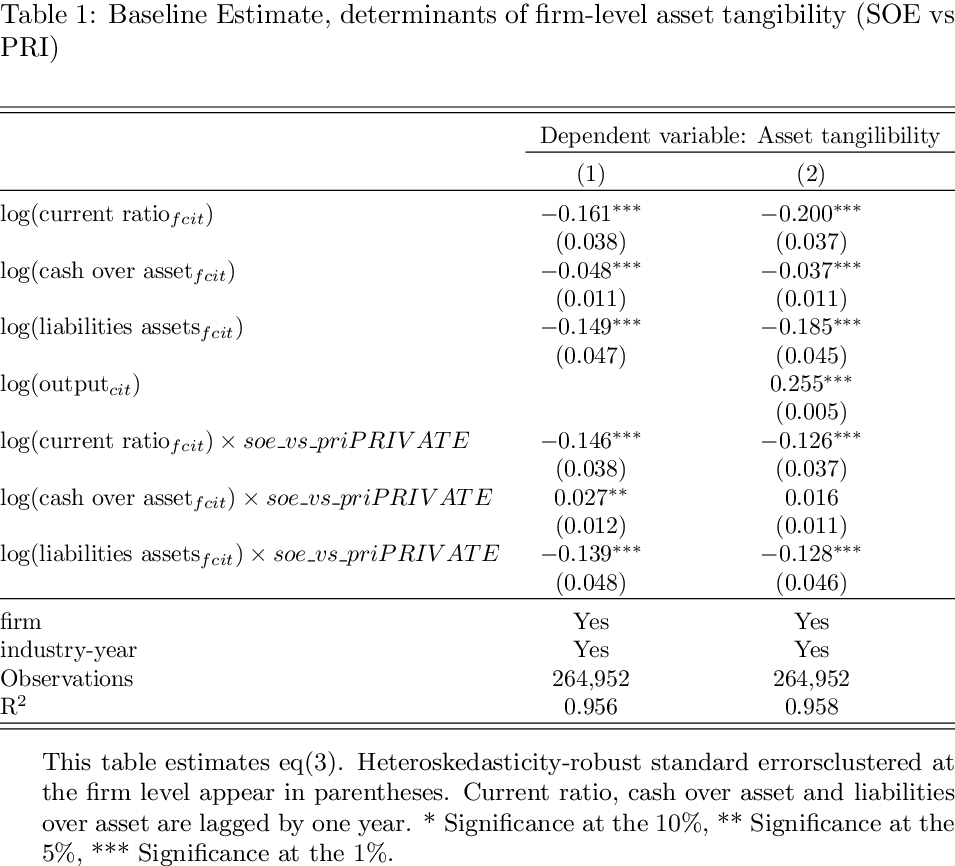

In [15]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the firm level appear in parentheses."\
" Current ratio, cash over asset and liabilities over asset are lagged by one year. "\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

#multicolumn ={
#    'Eligible': 2,
#    'Non-Eligible': 1,
#    'All': 1,
#    'All benchmark': 1,
#}

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200,
            folder = folder)

# Generate reports

In [16]:
import os, time, shutil, urllib, ipykernel, json
from pathlib import Path
from notebook import notebookapp

In [17]:
def create_report(extension = "html", keep_code = False, notebookname = None):
    """
    Create a report from the current notebook and save it in the 
    Report folder (Parent-> child directory)
    
    1. Exctract the current notbook name
    2. Convert the Notebook 
    3. Move the newly created report
    
    Args:
    extension: string. Can be "html", "pdf", "md"
    
    
    """
    
    ### Get notebook name
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[0].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+ \
                                             'api/sessions?token=' + \
                                             srv['token'])
            sessions = json.load(req)
            notebookname = sessions[0]['name']
        except:
            notebookname = notebookname  
    
    sep = '.'
    path = os.getcwd()
    #parent_path = str(Path(path).parent)
    
    ### Path report
    #path_report = "{}/Reports".format(parent_path)
    #path_report = "{}/Reports".format(path)
    
    ### Path destination
    name_no_extension = notebookname.split(sep, 1)[0]
    source_to_move = name_no_extension +'.{}'.format(extension)
    dest = os.path.join(path,'Reports', source_to_move)
    
    ### Generate notebook
    if keep_code:
        os.system('jupyter nbconvert --to {} {}'.format(
    extension,notebookname))
    else:
        os.system('jupyter nbconvert --no-input --to {} {}'.format(
    extension,notebookname))
    
    ### Move notebook to report folder
    #time.sleep(5)
    shutil.move(source_to_move, dest)
    print("Report Available at this adress:\n {}".format(dest))

In [ ]:
create_report(extension = "html", keep_code = False, notebookname = "04_asset_tang_firm_level.ipynb")